Профилирование пользователей. 

Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)

### Новости и пользователи

Есть набор новостей в новостной ленте.

И список пользователей.

In [ ]:
import pandas as pd

In [ ]:
news = pd.read_csv("/content/materials.csv")
print(news.shape)
news.head(5)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...
3,4898,Главный тренер «Кубани» Юрий Красножан прокомм...
4,4899,Решением попечительского совета владивостокско...


Загрузка пользователей и списков последних прочитанных новостей

In [ ]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### Получение векторных представлений новостей

In [ ]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [ ]:
#предобработка текстов
import re
import numpy as np

!pip install razdel
from razdel import tokenize

!pip install pymorphy2
import pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopword_ru = stopwords.words('russian')

morph = pymorphy2.MorphAnalyzer()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print(len(stopword_ru))

151


In [ ]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [ ]:
def clean_text(text):

    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [ ]:
%%time
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


CPU times: user 34 s, sys: 2.1 s, total: 36.1 s
Wall time: 43.3 s


In [ ]:
%%time
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 19s, sys: 805 ms, total: 4min 20s
Wall time: 4min 37s


In [ ]:
texts = [t for t in news['title'].values]

common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [ ]:
common_dictionary[197]

'почему'

### Обучение модели LDA

In [ ]:
from gensim.models import LdaModel

lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

In [ ]:
from gensim.test.utils import datapath

temp_file = datapath("model.lda")
lda.save(temp_file)

lda = LdaModel.load(temp_file)

### Иллюстрация тем

In [ ]:
other_texts = [t for t in news['title'].iloc[:1]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[0]
print(other_texts[0])
lda[unseen_doc] 

['заместитель', 'председатель', 'правительство', 'рф', 'сергей', 'иванов', 'избрать', 'председатель', 'совет', 'пбк', 'цска', 'прессслужба', 'армеец', 'решение', 'единогласно', 'принять', 'первый', 'заседание', 'совет', 'клуб', 'основной', 'функция', 'орган', 'обсуждение', 'текущий', 'состояние', 'планирование', 'утверждение', 'стратегия', 'развитие', 'клуб', 'близкий', 'перспектива', 'nn', 'состав', 'совет', 'войти', 'георгий', 'полтавченко', 'полномочный', 'центральный', 'федеральный', 'округ', 'алексей', 'седов', 'генералполковник', 'начальник', 'служба', 'защита', 'конституционный', 'строй', 'борьба', 'терроризм', 'фсб', 'рф', 'nn', 'александр', 'новак', 'заместитель', 'министр', 'финансы', 'рф', 'вячеслав', 'полтавец', 'заместитель', 'генеральный', 'директор', 'руководитель', 'блок', 'взаимодействие', 'орган', 'власть', 'социальный', 'корпоративный', 'политика', 'гмк', 'норильский', 'никель', 'nn', 'леонид', 'исакович', 'генеральный', 'директор', 'ооо', 'ук', 'спортивный', 'проект

[(7, 0.056355037), (14, 0.027252194), (22, 0.89972514)]

In [ ]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic{}: ".format(topic)+" ".join(words))

topic0: гражданин век остров турист тыс nn россиянин
topic1: исследователь выяснить мозг банк болезнь учёный риск
topic2: американский сша рак доллар метод фильм статья
topic3: космический погибнуть земля поверхность планета космос орбита
topic4: проект корабль станция научный наука строительство новый
topic5: исследование nn млрд россия обнаружить статья рынок
topic6: сигнал китайский японский уголь отель золото китай
topic7: женщина фестиваль nn мужчина участник мероприятие хороший
topic8: рынок земля область эксперимент участок площадь торговый
topic9: военный сша самолёт помощь спутник тело район
topic10: учёный университет nn животное клетка солнечный жизнь
topic11: писать египет пациент испытание новый небо летать
topic12: ракета луна высота производитель телескоп китай сша
topic13: операция государство соглашение товар россия глава российский
topic14: рост рубль цена уровень экономика система большой
topic15: гражданин продукция спрос оборудование снизиться рейс падение
topic16:

Теперь функция, которая возвращает векторное представление новости

In [ ]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [ ]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.056345,0.0,...,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.000000,0.899737,0.000000,0.000000
1,4896,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,...,0.051383,0.265514,0.507795,0.1149,0.000000,0.0,0.000000,0.000000,0.000000,0.040895
2,4897,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.092763,0.0,...,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.802871,0.000000,0.049563,0.000000
3,4898,0.0,0.0,0.0,0.020105,0.0,0.02068,0.0,0.080756,0.0,...,0.116708,0.000000,0.000000,0.0000,0.183603,0.0,0.320803,0.000000,0.000000,0.247279
4,4899,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,...,0.461744,0.000000,0.000000,0.0000,0.000000,0.0,0.000000,0.513391,0.000000,0.000000


### Векторные представления пользователей

In [ ]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [ ]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [ ]:
doc_dict[4896]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.05138262, 0.26551437, 0.50779504, 0.11490031, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.04089541])

Поэкспериментирую и проверю 3 статистики в создании вектора пользователя (медиана, среднее, максимум)

In [ ]:
def get_user_embedding_by_mean(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector


def get_user_embedding_by_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector


def get_user_embedding_by_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [ ]:
user_articles_list1 = get_user_embedding_by_median(users['articles'].iloc[197])
user_articles_list2 = get_user_embedding_by_mean(users['articles'].iloc[197])
user_articles_list3 = get_user_embedding_by_max(users['articles'].iloc[197])

print('median','\n',user_articles_list1,'\n',
      '\n', 'mean','\n',user_articles_list2,'\n','\n',
      'max','\n',user_articles_list3)

median 
 [0.02479574 0.         0.01497737 0.         0.         0.02761161
 0.         0.01244627 0.         0.         0.11258602 0.
 0.         0.         0.         0.         0.         0.01844127
 0.01094407 0.         0.09875923 0.         0.         0.
 0.0902675 ] 
 
 mean 
 [0.03038142 0.03069473 0.03704661 0.03554769 0.03277507 0.03726778
 0.01815805 0.03932718 0.01312741 0.02198664 0.15193712 0.
 0.00419783 0.01338864 0.02464575 0.01964023 0.0054693  0.03779629
 0.03122113 0.03967434 0.16104641 0.00931121 0.10353065 0.00506997
 0.08751179] 
 
 max 
 [0.07223199 0.15694314 0.16213173 0.12502553 0.12608077 0.10311797
 0.09515829 0.17890811 0.04810207 0.11574946 0.47833017 0.
 0.02518696 0.05058024 0.13522124 0.10486749 0.03281583 0.16068207
 0.09110057 0.17547065 0.51768106 0.0414038  0.37085402 0.03041982
 0.1798791 ]


В чем разница: взятие медианы дает более точечное представление тем в более разреженном векторе пользователя. 

Судя по всему, не учитываются выбросы в виде каких-то слишком часто/редко используемых слов.

Ну и в случае max берутся только самые значимые слова-темы.

Далее: 3 способа различаются в метрике.

In [ ]:
users['articles'].iloc[197]

'[290163, 294919, 294859, 294089, 294789, 2837]'

In [ ]:
" ".join(news[news['doc_id']==2837]['title'].iloc[0])

'гражданин россия погибнуть несчастный случай завод производство бетонный конструкция мост южнокорейский чхонджу летний мужчина придавить плита масса россиянин называться устанавливаться обстоятельство причина трагедия день чп взрыв пожар предприятие производство боеприпас тэджон погибнуть россиянин трагически погибнуть южный корея рёнхап несчастный случай произойти чхонджу завод производство бетонный конструкция мост данные летний мужчина придавить плита масса перемещение начать расследование устанавливаться точный причина обстоятельство произойти полицейский предстоять выяснить предприятие соблюдаться техника безопасность день трагедия унести жизнь южнокорейский тэджон погибнуть взрыв начаться пожар завод производство боеприпас взрыв произойти местный мск место происшествие прибыль единица пожарный техника возгорание удаться локализовать течение час пожарный начать проверка установление причина взрыв второе подобный чп взрыв последующий пожар предприятие тэджон двое рабочий погибнуть

In [ ]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_by_max(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.027785,0.045190,0.269837,0.100076,0.195167,0.153787,0.078341,0.223588,0.102272,...,0.246893,0.118818,0.405980,0.163326,0.062401,0.110360,0.028945,0.115978,0.282669,0.416336
1,u108690,0.035403,0.076782,0.354277,0.027242,0.014508,0.179278,0.000000,0.165070,0.207451,...,0.036930,0.121068,0.000000,0.294230,0.298338,0.033136,0.041896,0.063421,0.220419,0.274163
2,u108339,0.120106,0.044713,0.000000,0.093451,0.157267,0.154955,0.000000,0.017196,0.318476,...,0.096695,0.066452,0.011147,0.361125,0.045175,0.025508,0.049517,0.104959,0.016489,0.305498


### Обучение модели Логистической Регрессии для сегментации

In [ ]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [ ]:
X = pd.merge(user_embeddings, target, 'left', on='uid')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.027785,0.045190,0.269837,0.100076,0.195167,0.153787,0.078341,0.223588,0.102272,...,0.118818,0.405980,0.163326,0.062401,0.110360,0.028945,0.115978,0.282669,0.416336,0
1,u108690,0.035403,0.076782,0.354277,0.027242,0.014508,0.179278,0.000000,0.165070,0.207451,...,0.121068,0.000000,0.294230,0.298338,0.033136,0.041896,0.063421,0.220419,0.274163,1
2,u108339,0.120106,0.044713,0.000000,0.093451,0.157267,0.154955,0.000000,0.017196,0.318476,...,0.066452,0.011147,0.361125,0.045175,0.025508,0.049517,0.104959,0.016489,0.305498,1


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=197)

In [ ]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

LogisticRegression()

In [ ]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.03246073, 0.25583127, 0.59061757, 0.01675475, 0.00068778,
       0.00207067, 0.07710111, 0.0198615 , 0.44270839, 0.02846945])

### Метрики

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print('Best Threshold=%.4f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, ROC_AUC_score=%.4f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix],
                                                                        roc_auc_score(y_test, preds)))

Best Threshold=0.2880, F-Score=0.734, Precision=0.681, Recall=0.796, ROC_AUC_score=0.9532


In [ ]:
with open('max_using_metrics.txt', 'wb') as f:
  f.write(('Best Threshold=%.4f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, ROC_AUC_score=%.4f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix],
                                                                        roc_auc_score(y_test, preds))).encode('utf-8'))


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1650   95]
 [  53  202]]


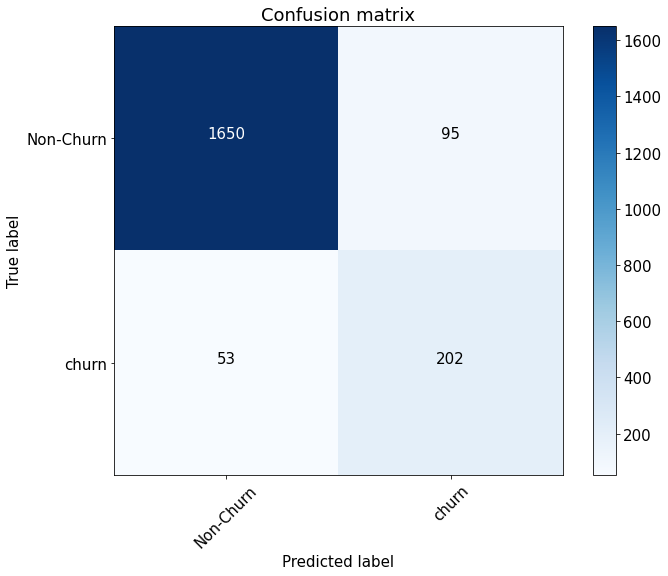

In [ ]:
font = {'size' : 15}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_using_max.png")
plt.show()

In [ ]:
with open('/content/max_using_metrics.txt', 'r') as f:
  max_metrics = f.read()

In [ ]:
with open('/content/mean_using_metrics.txt', 'r') as f:
  mean_metrics = f.read()

In [ ]:
with open('/content/median_using_metrics.txt', 'r') as f:
  median_metrics = f.read()

In [ ]:
for i in [max_metrics, median_metrics, mean_metrics]:
  i = i.split(', ')

In [ ]:
print('\n',mean_metrics,'\n',median_metrics,'\n',max_metrics)


 Best Threshold=0.7391, F-Score=nan, Precision=0.000, Recall=0.000,  ROC_AUC_score=0.9373 
 Best Threshold=0.2363, F-Score=0.682, Precision=0.663, Recall=0.702,  ROC_AUC_score=0.9411 
 Best Threshold=0.2880, F-Score=0.734, Precision=0.681, Recall=0.796, ROC_AUC_score=0.9532


(Поленился автоматизировать процесс и выдать 3 способа получения эмбедингов и их метрики в один шаг.)

Результаты удовлетворительные, если не брать в расчет mean. Лучше всего использовать взятие максимальных значений вектора пользователя.








